# Loading Dependencies

In [1]:
#Loading Dependencies

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import h5py
import os
import sklearn as sk
from sklearn.decomposition import PCA
from timeit import default_timer as timer


from PIL import Image
from IPython.display import display


work_dir = os.getcwd()
print('Current working directory:')
print(work_dir)




print(os.listdir("./data"))

Current working directory:
C:\Users\thorb\OneDrive\Documents\Math TU Delft\USYD ML2\COMP5328 Project 2
['CIFAR.npz', 'FashionMNIST0.5.npz', 'FashionMNIST0.6.npz']


# Loading Data

## 1. Fashion MNIST0.5 

In [2]:
data1 = np.load(work_dir + "./data/FashionMNIST0.5.npz")
X_train1 = data1['Xtr']
Y_train1 = data1['Str']
X_test1 = data1['Xts']
Y_test1 = data1['Yts']

X_train1.shape, Y_train1.shape, X_test1.shape, Y_test1.shape

((18000, 28, 28), (18000,), (3000, 28, 28), (3000,))

In [3]:
set(Y_train1)

{0, 1, 2}

In [5]:
for k in np.random.randint(18000, size=10):
    X_image = X_train1[k]
    display(Image.fromarray(X_image))


## 2. MNIST 0.6

In [6]:
data2 = np.load(work_dir + "./data/FashionMNIST0.6.npz")
X_train2 = data2['Xtr']
Y_train2 = data2['Str']
X_test2 = data2['Xts']
Y_test2 = data2['Yts']

X_train2.shape, Y_train2.shape, X_test2.shape, Y_test2.shape

((18000, 28, 28), (18000,), (3000, 28, 28), (3000,))

In [7]:
set(Y_train2)

{0, 1, 2}

In [8]:
for k in np.random.randint(18000, size=10):
    X_image = X_train2[k]
    display(Image.fromarray(X_image))


# CIFAR

In [9]:
data3 = np.load(work_dir + "./data/CIFAR.npz")
X_train3 = data3['Xtr']
Y_train3 = data3['Str']
X_test3 = data3['Xts']
Y_test3 = data3['Yts']

X_train3.shape, Y_train3.shape, X_test3.shape, Y_test3.shape

((15000, 32, 32, 3), (15000,), (3000, 32, 32, 3), (3000,))

In [10]:
set(Y_train3)

{0, 1, 2}

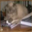

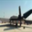

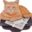

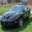

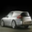

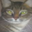

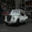

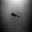

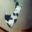

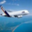

In [11]:
for k in np.random.randint(15000, size=10):
    X_image = X_train3[k]
    display(Image.fromarray(X_image))

## Preprocessing

In [12]:
def encode(Y):
    n,c = Y.size, len(set(Y))
    Y_encoded = np.zeros((n,c))
    
    for i in range(n):
        Y_encoded[i,Y[i]] = 1
    
    return Y_encoded
    
    

In [13]:
encode(Y_train1).shape

(18000, 3)

# Models

## Multinomial

In [14]:
#For c-dim vector, returns c-dim vector exp(vector_c)/sum(exp_(vector_c))
def softmax(array):
    n,c = array.shape

    temp = np.exp(array)
    
    temp2 = np.sum(temp,axis = 1) #our input: XW nxC -> sum row-wise
    
    result = temp/temp2.reshape(n,1) #division, row wise
    
    return result
    
#Returns:
#Row-wise: softmax(array_row1), softmax(array_row2),...,softmax(array_rown)
# working as intended
    

In [15]:
# X nxp data
# W pxc weights for every class
def mu(X,W):
    XW = X@W
    
    return softmax(XW)
    
#rows of XW are <X_row_i, W_column_j>
# row of X: data samples
# j column of W: weights for class j \in {0,1,2}
# Thus, returns: softmax(X_i, class_j) = exp(x_i*w_j)/sum_c exp(x_i*W_c)
    

In [16]:
# Returns the gradient of the cross error entropy function in W (as per Murphy)
# X nxp
# W pxC
# Y (encoded) nxC
def ceef_grad(X,W,Y):
    mu_matrix = mu(X,W) #nxc
    n,p = X.shape
    p,c = W.shape
    
    grad = np.zeros((p,c))
    for i in range(n):
        grad += np.transpose(np.kron((mu_matrix[i,:] - Y[i,:]),X[i,:]).reshape(c,p))
        #reshape: reshapes a matrix by filling up rows first, we need columns first, thus the transpose with interchange p,c
    
    return grad

In [17]:
def multinomial_grad_descent(X,W,Y,eta,max_iter,tol):
    Y = encode(Y)
    
    grad = ceef_grad(X,W,Y)
    diff = np.linalg.norm(eta * grad)
    iter = 0
    
    while (diff > tol) and iter < max_iter:
        if iter%500 == 0:
            print('Iter:' + str(iter))
            print('Current diff' + str(diff))
        
        W = W - eta * grad
        
        #new gradient:
        grad = ceef_grad(X,W,Y)
        #new diff:
        diff = np.linalg.norm(eta*grad)
        iter += 1
    return W
    

In [272]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = scaler.fit_transform(X_train1[:1000,:].reshape(1000,28*28))
Y = Y_train1[:1000]
#W = np.random.randint(5,size=(28*28,3))
W =  0.01* np.random.rand(28*28,3)
result = multinomial_grad_descent(X, W, Y, 0.0001, 10000, 0.0000001)

C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thorb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Iter:0
Current diff0.1531218322999114
Iter:500
Current diff0.24075526458753607
Iter:1000
Current diff0.1661749498238168
Iter:1500
Current diff0.1174096831070201
Iter:2000
Current diff0.07354128401347525
Iter:2500
Current diff0.023055639679453028
Iter:3000
Current diff0.0018913971581760323
Iter:3500
Current diff0.0017443882063014839
Iter:4000
Current diff0.0016255487660302784
Iter:4500
Current diff0.0015266119452727995
Iter:5000
Current diff0.0014425901268019952
Iter:5500
Current diff0.0013701399769798998
Iter:6000
Current diff0.001306893503857958
Iter:6500
Current diff0.0012511105544773663
Iter:7000
Current diff0.0012014763170707197
Iter:7500
Current diff0.0011569748245842408
Iter:8000
Current diff0.0011168062137533916
Iter:8500
Current diff0.0010803307541471785
Iter:9000
Current diff0.0010470299247884998
Iter:9500
Current diff0.0010164786622627246
